# Fashion MNIST

- [pytorch/tutorials/beginner_source/basics/quickstart_tutorial](https://github.com/pytorch/tutorials/blob/master/beginner_source/basics/quickstart_tutorial.py)
- https://www.youtube.com/watch?v=lcjQYorHP2w

## 1. Moudle Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

## 2. Device Check

In [2]:
# Get cpu or gpu device for training.
if torch.cuda.is_available():
  DEVICE = torch.device('cuda:0')
else:
  DEVICE = torch.deivce('cpu')

print('Using Pytorch version : ',  torch.__version__, 'DEVICE : ', DEVICE)

Using Pytorch version :  1.12.1+cu113 DEVICE :  cuda:0


## 3. Download FashionMNIST Data 

In [3]:
# Download training data from datasets
train_data = datasets.FashionMNIST(
    root='../data/FashionMNIST',
    train=True,
    download=True,
    transform=ToTensor(),   # ToTensor()로 tensor 형태로
)

In [4]:
# Download test data from datasets
test_data = datasets.FashionMNIST(
    root='../data/FashionMNIST',
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
BATCH_SIZE = 32
EPOCHS = 20

In [6]:
# Create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

## 4. Check Data

In [7]:
for (X_train, y_train) in train_loader:
  print(f'Shape of X_train [N, C, H, W] : {X_train.shape}', f'\nType of X_train : {X_train.dtype}\n')  # X_train.type() : torch.FloatTensor
  print(f'Shape of y_train [N, C, H, W] : {y_train.shape}', f'\nType of y_train : {y_train.dtype}')  # y_traon.type() : torch.LongTensor
  break

  # [Mini-Batch, Channel, Height, Width]
  # Channel = 1 : 흑백 이미지

Shape of X_train [N, C, H, W] : torch.Size([32, 1, 28, 28]) 
Type of X_train : torch.float32

Shape of y_train [N, C, H, W] : torch.Size([32]) 
Type of y_train : torch.int64


In [8]:
for (X_test, y_test) in test_loader:
  print(f'Shape of X_test [N, C, H, W] : {X_test.shape}', f'\nType of X_test : {X_test.dtype}\n')  # X_train.type() : torch.FloatTensor
  print(f'Shape of y_test [N, C, H, W] : {y_test.shape}', f'\nType of y_test : {y_test.dtype}')  # y_traon.type() : torch.LongTensor
  break

  # [Mini-Batch, Channel, Height, Width]
  # Channel = 1 : 흑백 이미지

Shape of X_test [N, C, H, W] : torch.Size([32, 1, 28, 28]) 
Type of X_test : torch.float32

Shape of y_test [N, C, H, W] : torch.Size([32]) 
Type of y_test : torch.int64


In [9]:
label_mapping = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot",
}

Ankle boot


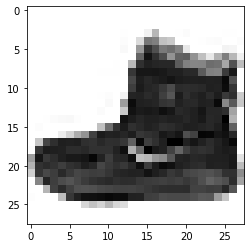

In [10]:
image, label = next(iter(train_data))
plt.imshow(image.squeeze(), cmap="binary")
print(label_mapping[label])

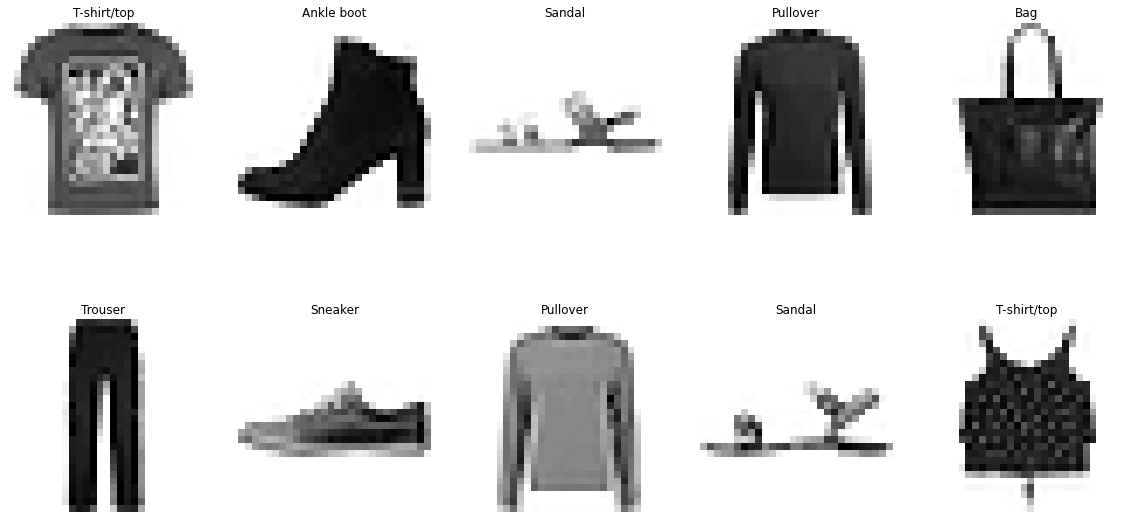

In [11]:
plt.figure(figsize=(20, 10))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].squeeze(), cmap='binary')  # X_train [32, 1, 28, 28] -> [i, :, :, :] -> squeeze() -> [28, 28]
  plt.title(label_mapping[y_train[i].item()])

## Define Model : MLP (Multi Layer Perceptron)

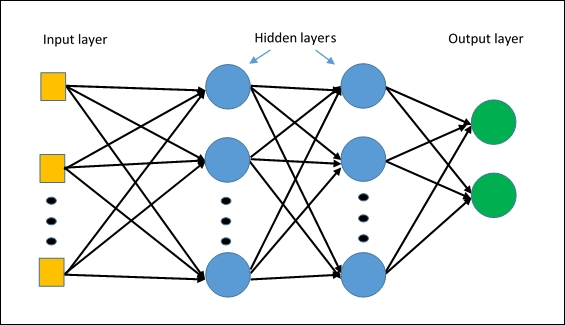

In [12]:
X_train.view(-1, 28*28).shape

torch.Size([32, 784])

In [13]:
m = nn.Flatten()
m(X_train).size()

torch.Size([32, 784])

In [14]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()  # x.view(-1, 28*28) [BATCH_SIZE, 784]
    self.fc1 = nn.Linear(28*28, 512)
    self.batch_norm1 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(512, 256)
    self.batch_norm2 = nn.BatchNorm1d(256)
    self.fc3 = nn.Linear(256, 128)
    self.batch_norm3 = nn.BatchNorm1d(128)
    self.fc4 = nn.Linear(128, 64)
    self.batch_norm4 = nn.BatchNorm1d(64)
    self.fc5 = nn.Linear(64, 10)
    self.dropout_prob = 0.1

  def forward(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.batch_norm1(x)
    x = F.leaky_relu(x)
    x = F.dropout(x, training=self.training, p=self.dropout_prob)
    x = self.fc2(x)
    x = self.batch_norm2(x)
    x = F.leaky_relu(x)
    x = F.dropout(x, training=self.training, p=self.dropout_prob)
    x = self.fc3(x)
    x = self.batch_norm3(x)
    x = F.leaky_relu(x)
    x = F.dropout(x, training=self.training, p=self.dropout_prob)
    x = self.fc4(x)
    x = self.batch_norm4(x)
    x = F.leaky_relu(x)
    x = F.dropout(x, training=self.training, p=self.dropout_prob)
    x = self.fc5(x)
    x = F.log_softmax(x, dim=1)
    return x 

## Model, Optimizer, Loss Function

In [15]:
model = NeuralNetwork().to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()    # To traiin

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)


## Check the model's performance against the **train** data

In [16]:
def train(model, train_loader, criterion, optimizer, interval):
  size = len(train_loader.dataset)
  model.train()

  for batch_idx, (X, y) in enumerate(train_loader):   # X : image, y : label
    X, y = X.to(DEVICE), y.to(DEVICE)

    # Compute prediction error
    pred = model(X)
    loss = criterion(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % interval == 0:
      loss, current_idx = loss.item(), batch_idx * len(X)
      print(f"loss: {loss:>7f}  [{current_idx:>5d}/{size:>5d}]")

## Check the model's performance against the **test** data

In [17]:
test_loss_list = []
test_accuracy_list = []

In [18]:
def evaluate(model, test_loader, criterion):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0
    
    model.eval()

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    test_loss_list.append(test_loss)
    test_accuracy_list.append(100.*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Check Loss, Accuracy During Epochs

In [19]:
for Epoch in range(1, EPOCHS+1):
  print(f'Epoch {Epoch}\n----------------------')
  train(model, train_loader, criterion, optimizer, interval=100)
  evaluate(model, test_loader, criterion)
  print('Done!\n')

Epoch 1
----------------------
loss: 2.398241  [    0/60000]
loss: 0.839990  [ 3200/60000]
loss: 0.736672  [ 6400/60000]
loss: 0.397828  [ 9600/60000]
loss: 0.759163  [12800/60000]
loss: 0.628154  [16000/60000]
loss: 0.462258  [19200/60000]
loss: 0.542045  [22400/60000]
loss: 0.318655  [25600/60000]
loss: 0.485355  [28800/60000]
loss: 0.232334  [32000/60000]
loss: 0.783715  [35200/60000]
loss: 0.360939  [38400/60000]
loss: 0.357646  [41600/60000]
loss: 0.627946  [44800/60000]
loss: 0.497882  [48000/60000]
loss: 0.613678  [51200/60000]
loss: 0.423504  [54400/60000]
loss: 0.385134  [57600/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.364415 

Done!
Epoch 2
----------------------
loss: 0.408830  [    0/60000]
loss: 0.320902  [ 3200/60000]
loss: 0.344501  [ 6400/60000]
loss: 0.434445  [ 9600/60000]
loss: 0.576022  [12800/60000]
loss: 0.390567  [16000/60000]
loss: 0.262363  [19200/60000]
loss: 0.291821  [22400/60000]
loss: 0.280803  [25600/60000]
loss: 0.768637  [28800/60000]
loss: 0.38